# K-Means Clustering

Your assignment is to use the TMDB 5000 dataset from Kaggle to try and cluster similar movies. 

It may be helpful to use PCA to reduce the dimensions of your data first - but then again maybe not. I dunno, you're the data scientist, you tell me. 🤪 

I'll let you download the dataset and get it into your notebook in the way that works best for you:

<https://www.kaggle.com/tmdb/tmdb-movie-metadata/version/2>

There are a few weird data cleaning steps that you'll need to do that I don't want you to get stuck on or spend a lot of time on so I'll try and help you out a little bit. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/tmdb_5000_movies.csv")
print(df.shape)
df.head()

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [0]:
# There's probably some pandas function that will do this but...
str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in df.iteritems():
    if type(colvalue[1]) == str:
         str_list.append(colname)
# Get to the numeric columns by inversion            
num_list = df.columns.difference(str_list)  

In [4]:
# Filter the dataframe by only the numeric columns
df_numeric = df[num_list]
df_numeric.head()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
0,237000000,19995,150.437577,2787965087,162.0,7.2,11800
1,300000000,285,139.082615,961000000,169.0,6.9,4500
2,245000000,206647,107.376788,880674609,148.0,6.3,4466
3,250000000,49026,112.312950,1084939099,165.0,7.6,9106
4,260000000,49529,43.926995,284139100,132.0,6.1,2124


In [0]:
# lazily fill NaNs with zeros
movie_num = df_numeric.fillna(value=0, axis=1)

In [6]:
movie_num.shape

(4803, 7)

# You take it from here!

See what you can come up with. You have all the know-how! 

In [0]:
##### Your Code Here #####
!pip install seaborn==0.9.0 -q

%matplotlib inline
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns; sns.set()


# I think PCA is fitting here, because the features we want to look at have 
# vastly different scales and i think it's intuitive that there are probably 
# linear relationships between some of these features, and id like to figure out 
# if there is a strong outlier of indication towards popularity

# after i've found my features that I want to work with to show a strong 
# relationship, i can feed those features into a cluster.


In [8]:
# step 1: seperate data into x(our features), to predict y, i want to predict 
# a movie's expected vote average


# dropped the ID, as all the id's are unique, so we let the index act as the ID

#x = pd.DataFrame(movie_num.drop(['popularity'], axis=1))

x = movie_num

y = movie_num['popularity']

# we can use scipy to normalize our data

scaler = StandardScaler()
X_standard = scaler.fit_transform(x)



/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


No handles with labels found to put in legend.



 Eigenvectors: 
 [[ 0.42955888 -0.06779967  0.45577203  0.48744498  0.25254313  0.23292115
   0.49751516]
 [ 0.15819614  0.60459644  0.15529443  0.17519204 -0.45149207 -0.5775
   0.13144268]
 [-0.34273569  0.7334906   0.14554958 -0.17822059  0.38140145  0.37625325
   0.06740142]
 [-0.3550502  -0.11671238  0.30378859 -0.04322275 -0.71780564  0.45699826
   0.20510853]
 [-0.4894082  -0.2784456   0.53924    -0.1956749   0.26075222 -0.50171217
   0.1848578 ]]

 Eigenvalues: 
 [3.27639513 1.34750731 0.83788985 0.70982729 0.41233718]


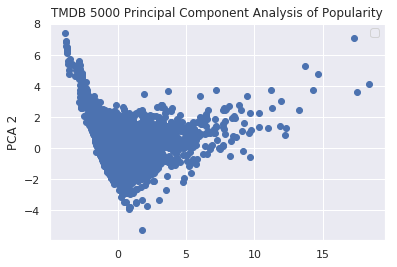

In [21]:
# reduce to two dimensions
pca = PCA(n_components=5)

pca_1 = pca.fit_transform(X_standard)
print("\n Eigenvectors: \n", pca.components_)
print("\n Eigenvalues: \n",pca.explained_variance_)

pca_complete = pca.transform(X_standard)

pca_figure, pca_axis = plt.subplots()

pca_axis.set_title('TMDB 5000 Principal Component Analysis of Popularity')

pca_axis.scatter(pca_complete[:,0], pca_complete[:,1])



pca_axis.set_ylabel('PCA 1')
pca_axis.set_ylabel('PCA 2')

pca_axis.legend()
plt.show()




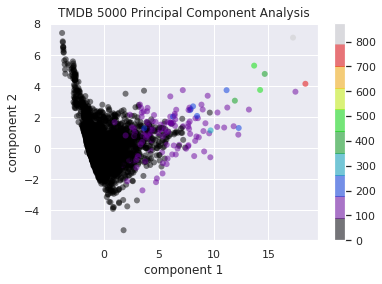

In [10]:
plt.scatter(pca_complete[:, 0], pca_complete[:, 1],
            c=y, edgecolor='none', alpha=.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))


plt.title('TMDB 5000 Principal Component Analysis')

plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

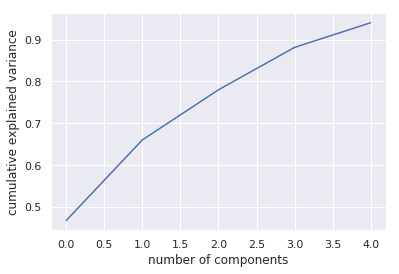

In [11]:
# BLAST YOU darkly colored feature....


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');


# so uh, just use all of them...we want >90 variance

In [0]:

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
kmeans_fitted = kmeans.fit(pca_complete)
labels = kmeans_fitted.labels_

movie_num['clusters'] = labels

Text(0.5,1,'Clustering (K=5) After PCA')

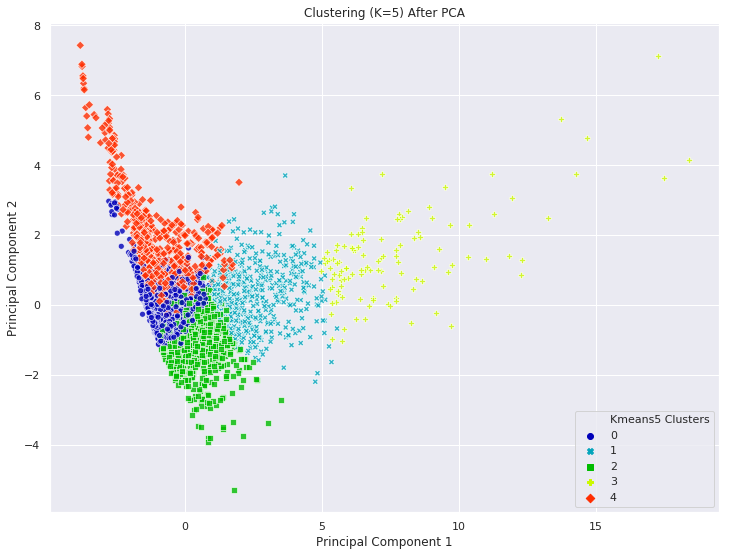

In [36]:


palette = sns.color_palette("nipy_spectral", 5)



pca_cluster_df = pd.DataFrame({'Principal Component 1' : pca_complete[:,0]
                                  ,'Principal Component 2' : pca_complete[:,1]})

pca_cluster_df['Kmeans5 Clusters'] = labels 


fig, ax = plt.subplots(figsize=(12,9))
sns.scatterplot(ax=ax, x='Principal Component 1', y='Principal Component 2', 
                data=pca_cluster_df, 
                hue='Kmeans5 Clusters',
                style='Kmeans5 Clusters',
                alpha=0.8,
                palette=palette,
                legend='full')

ax.set_title('Clustering (K=5) After PCA')



# Stretch Goal:

If you look at the original dataset you'll notice that I threw away some potentially useful columns. See if there are any that you could clean more effectively and turn into a numeric representation (probably some kind of one-hot-encoding of categorical variables) to assist your clustering. There's a lot more work here than the hours we have today however, so don't kill yourself trying to incorporate every single column from the original dataset, just take it one column at a time.

**Side Note** Data Science is never DONE. You just reach a point where the cost isn't worth the benefit anymore. There's always more moderate to small improvements that we could make. Don't be a perfectionist, be a pragmatist.